In [66]:
from PIL import Image
import json
from pycocotools import mask
import matplotlib.pyplot as plt
import numpy as np
import os

with open("/app/derender_proposals/proposal_10003.json") as file:
    derender_dict = json.load(file)

In [ ]:
def mean_center_of_mask(mask):
    # Get the coordinates of all non-zero pixels (foreground pixels)
    foreground_pixels = np.column_stack(np.where(mask == 1))

    if foreground_pixels.shape[0] == 0:
        return None  # Return None if there are no foreground pixels

    # Calculate the mean center (centroid) by averaging the coordinates
    mean_y = int(
        np.round(np.mean(foreground_pixels[:, 0]))
    )  # Mean of y-coordinates (rows)
    mean_x = int(
        np.round(np.mean(foreground_pixels[:, 1]))
    )  # Mean of x-coordinates (columns)

    return mean_x, mean_y  # Return the (x, y) coordinates of the centroid


def crop_images_around_object(
    image_filenames: list[str],
    object_attributes: dict,
    derender: dict,
    target_folder: str,
    cropped_img_size=128,
):
    derender_frames = derender["frames"]
    padding_size = int(np.ceil(cropped_img_size / 2))

    for i, frame_dict in enumerate(derender_frames):
        objects_in_frame = frame_dict["objects"]
        video_frame = np.array(Image.open(image_filenames[i]))
        for ob in objects_in_frame:
            ob_attributes = {key: ob[key] for key in object_attributes.keys()}
            if ob_attributes == object_attributes:
                binary_mask = mask.decode(ob["mask"])
                mask_center = mean_center_of_mask(binary_mask)

                padded_video_frame = np.pad(
                    video_frame,
                    (
                        (padding_size, padding_size),
                        (padding_size, padding_size),
                        (0, 0),
                    ),
                    mode="reflect",
                )
                cropped_img = padded_video_frame[
                    mask_center[1] : mask_center[1] + 2 * padding_size,
                    mask_center[0] : mask_center[0] + 2 * padding_size,
                    :,
                ]
                Image.fromarray(cropped_img).save(
                    os.path.join(target_folder, os.path.basename(image_filenames[i]))
                )

                break

In [ ]:
base_path = "/app/ncb/edited_videos/video_10003/video_frames"
frame_names = sorted(os.listdir(base_path))
target_folder = "/app/ncb/square_imgs/video_10003"
frame_names = [os.path.join(base_path, frame_name, target_folder) for frame_name in frame_names]
object_attributes = {
    "color": "blue",
    "material": "metal",
    "shape": "sphere",
}
crop_images_around_object(frame_names, object_attributes, derender_dict)

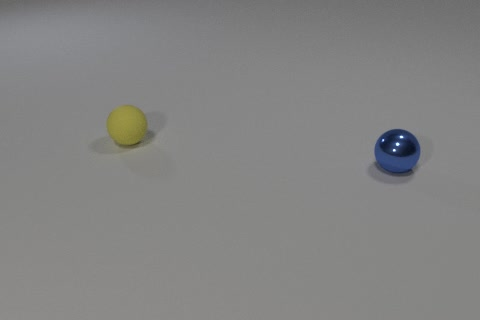

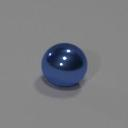

In [75]:
Image.open("/app/ncb/edited_videos/video_10003/video_frames/00000.jpg").show()
Image.open("/app/ncb/square_imgs/video_10003/00000.jpg").show()